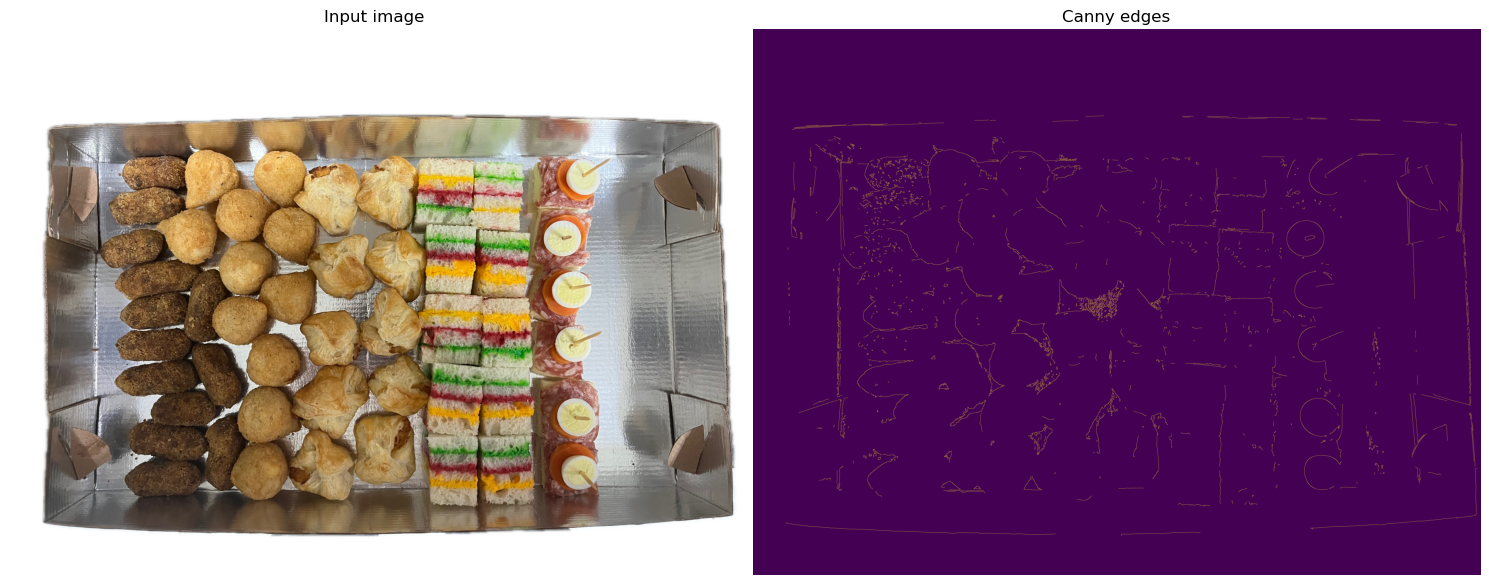

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import cv2
from matplotlib import pyplot as plt

IMAGE_PATH = 'dataset/trim/IMG_2426.jpeg'


def applyCanny(source, threshold1, threshold2, apertureSize, L2gradient):
    image = cv2.imread(source) 
    if image is None:
        print("Error: Could not load image.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise (optional but recommended)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    edges = cv2.Canny(blurred_image, threshold1=threshold1, threshold2=threshold2, apertureSize=apertureSize, L2gradient=L2gradient) 

    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[0].set_title('Input image')

    ax[1].imshow(edges)
    ax[1].set_title('Canny edges')

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()


#interact_manual(applyCanny, source=IMAGE_PATH, threshold1=120, threshold2=230, apertureSize=3, L2gradient=True)
applyCanny(source=IMAGE_PATH, threshold1=120, threshold2=230, apertureSize=3, L2gradient=True)